# Easy Patch Sampling

DESCRIPTION: This code extracts patches from a .svs histology slide image  
INPUT: a folder of images  
OUTPUT: a dictionary of patches by file

Note: Level count is going to tell you how far you can zoom the image. I'm taking the highest amount you can zoom the image, then extracting patches

In [42]:
import openslide
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from openslide import deepzoom

In [21]:
FILETYPE = '.svs'
FILE_DIR = 'images'
TILE_SIZE = 1000 # pixel size of image
WHITESPACE_CUTOFF = 0.35 # how much whitespace will you allow: [0, 1]
COMMENT_TOGGLE = False # do you want a comment that says tile is acceptable or not

In [3]:
def extract_patches(osr_obj):
    """Description: Uses openslide to extract patches at closest zoom size
    INPUT: an openslide object (the .svs image)
    OUTPUT: a list of tiles as image objects
    """
    list_of_tiles = []
    
    t = openslide.deepzoom.DeepZoomGenerator(m, tile_size=TILE_SIZE, overlap=0, limit_bounds=False)
    max_level = t.level_count
    
    addresses = t.level_tiles[max_level-1] # zoomed in to furthest amount
    
    for x_coord in range(addresses[0]):
        for y_coord in range(addresses[1]):
            list_of_tiles.append(t.get_tile(max_level - 1, (x_coord, y_coord)))
    
    return list_of_tiles

In [4]:
def check_if_white(pixel):
    """DESCRIPTION: Checks to see if a given pixel is an off-white or white pixel
    INPUT: 3x1 tuple, where each element is in range [0,255]
    OUTPUT: 1 : is a whitespace
            0 : is not a whitespace
    """
    for x in pixel:
        if x < 230:
            return 0
    return 1

In [5]:
def determine_quality(img):
    """Description: Determines quality of a histology tile image
    INPUT: Tile (Image object)
    OUTPUT: 0 : too much whitespace
            1 : acceptable image
    
    """
    p = img.load()
    img_size = img.size
    
    total = 0
    
    for y in range(img_size[1]):
        for x in range(0,img_size[0],3):
            if check_if_white(p[x,y]):
                total += 1

    if total / (img_size[0] * img_size[1] / 3) > WHITESPACE_CUTOFF:
        if COMMENT_TOGGLE:
            print("too much whitespace")
        return 0
    else:
        if COMMENT_TOGGLE:
            print("acceptable")
        return 1

## Run Code

In [23]:
files = os.listdir(FILE_DIR)
files = [x for x in files if FILETYPE in x]

In [24]:
files[0]

'Astrocytomas-Gliogene-Huse-073.svs'

In [27]:
all_images = {}
for file in files:
    m = openslide.OpenSlide('%s/%s' % (FILE_DIR, file))
    print(file, m.dimensions)
    
    print('Extracting patches...')
    d = extract_patches(m)
    all_images[file] = []

    print('Removing patches with too much whitespace...')
    for img in tqdm(d):
        if determine_quality(img):
            all_images[file].append(img)

Astrocytomas-Gliogene-Huse-073.svs (47808, 33480)
Extracting patches...


  0%|          | 1/1632 [00:00<04:15,  6.38it/s]

Removing patches with too much whitespace...


100%|██████████| 1632/1632 [03:27<00:00,  7.85it/s]


In [31]:
for key in all_images:
    print(len(all_images[key]))

869
550
204
603


## Save patches to image

In [57]:
def pad(i, n):
    """ PADS AN INTEGER
    INPUT: i : [int] number to be padded
           n : [int] total length of padded number
    OUTPUT: str
    """
    i = str(i)
    l = len(i)
    
    if l > n:
        raise ValueError('Integer is bigger than padding specifications')
    else:
        return ('0' * (n-l)) + i

In [60]:
out_dir = 'patches'

for key in all_images:
    os.mkdir('%s/%s' % (out_dir, key[:-4]))
    i = 0
    
    for img in all_images[key]:
        name = 'patch' + pad(i,4)
        img.save('%s/%s/%s.png' % (out_dir, key[:-4], name),'PNG')
        i += 1

## Visualize

See first 100 accepted images

In [28]:
filename = files[0]

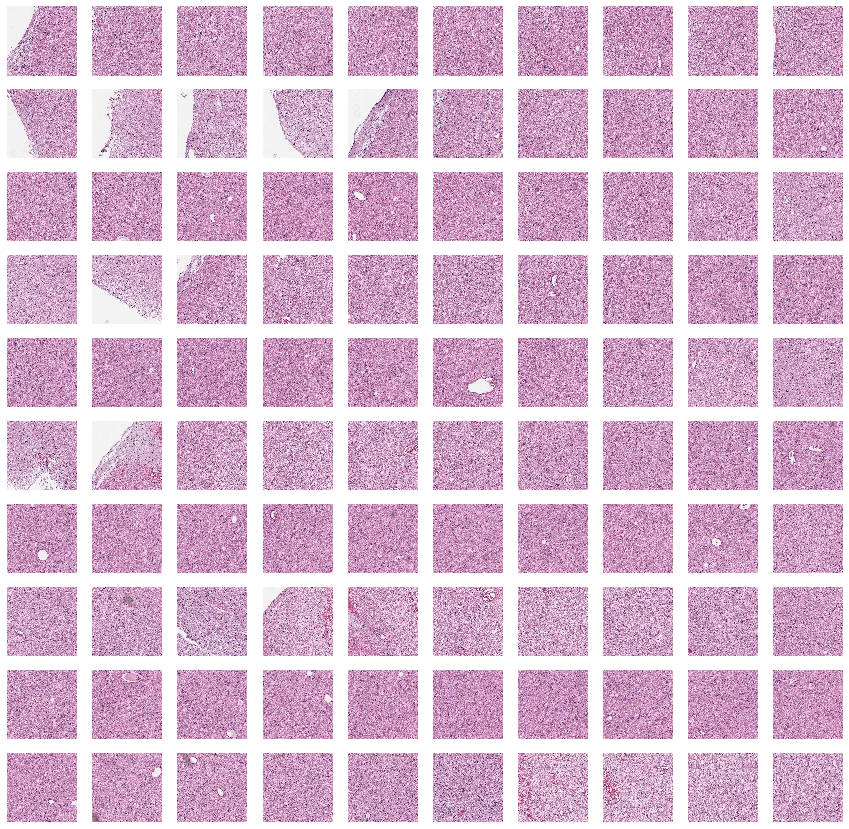

In [29]:
fig, axes = plt.subplots(10,10, figsize=(15,15) )
tot = 0

for i in range(10):
    for j in range(10):
        axes[i,j].imshow(all_images[filename][tot])
        axes[i,j].axis('off')
        tot += 1
plt.show()